# **CV Pipeline**

Le but de ce notebook et d'enchaîner la séquences des transformations distribuées sur plusieurs sections dans les autres notebooks, qui ont vocation de support de présentation.

La motivation principale a été de pouvoir multiplier les configurations testées sans devoir remonter toutes les chaînes, en particulier de tester les différentes méthodes d'analyse factorielle proposées par Scikit-learn.

Ici, l'exécution est complète et complètement déterminée par un configuration donnée en entrée.

# Réduction TSNE

In [1]:
from im_prep import get_all_1050_dir
from im_ml import load_red_im_features
data_name = "_red_pca_0.99_full_equ_rsz_gray_ocv_orb_feats"
feats = load_red_im_features(get_all_1050_dir, data_name)

(1050, 583)

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 009099b1f6e1e8f893ec29a7023153c4 to fffa2117a4006d4a848eb7d5b80d4816
Columns: 583 entries, 0 to 582
dtypes: float64(583)
memory usage: 4.7+ MB


In [ ]:
from im_ml import tsne_reduction
tsne_feats = tsne_reduction(feats)

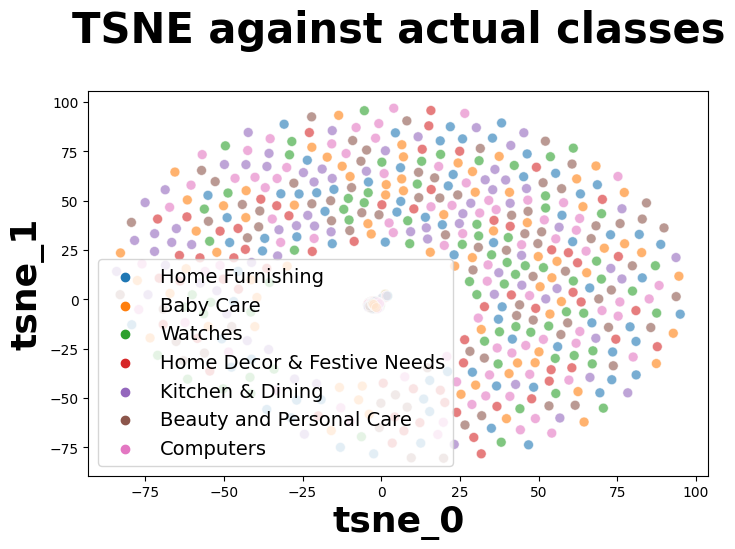

In [4]:
from flipkart_utils import get_class_names
from im_ml import show_tsne
show_tsne(tsne_feats, get_class_names(), "classes")

# Autres réductions de dimensionnalité

Voir chapitre [**Décomposer des signaux en composantes (problèmes de factorisation matricielle)** (2.5)](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/2_5_decomposition.ipynb) de la documentation Scikit-learn.

## Charger les données

In [6]:
from im_prep import get_all_1050_dir
from im_ml import load_im_features
# o data_name = "rsz_gray_ski_sift_feats"
# o data_name = "rsz_gray_ski_orb_feats"
# o data_name = "rsz_gray_ocv_sift_feats"
# o data_name = "rsz_gray_ocv_orb_feats"
# o data_name = "equ_rsz_gray_ski_sift_feats"
# o data_name = "equ_rsz_gray_ski_orb_feats"
# o data_name = "equ_rsz_gray_ocv_sift_feats"
data_name = "equ_rsz_gray_ocv_orb_feats"
feats = load_im_features(get_all_1050_dir, data_name)
display(feats.shape)

(1050, 716)

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 009099b1f6e1e8f893ec29a7023153c4 to fffa2117a4006d4a848eb7d5b80d4816
Columns: 716 entries, 0 to 715
dtypes: float64(716)
memory usage: 5.7+ MB


(1050, 716)

## PCA et kPCA

### PCA

In [7]:
from sklearn import decomposition
# n_components = 'mle'  # 0.99,  MLE, bcp + long qu'avec % de var expliquée - contrainte n_smpl > n_feats
n_components = 0.99
svd_solver = 'full'   # {‘auto’, -> ‘full’, ‘arpack’, ‘randomized’}

print("Dimensions before PCA:", feats.shape)
pca = decomposition.PCA(
    n_components=n_components,
    whiten=True,
    svd_solver=svd_solver,
    random_state=42
)
pca_feats = pca.fit_transform(feats)
print("Dimensions after PCA:", pca_feats.shape)

Dimensions before PCA: (1050, 716)
Dimensions after PCA: (1050, 583)


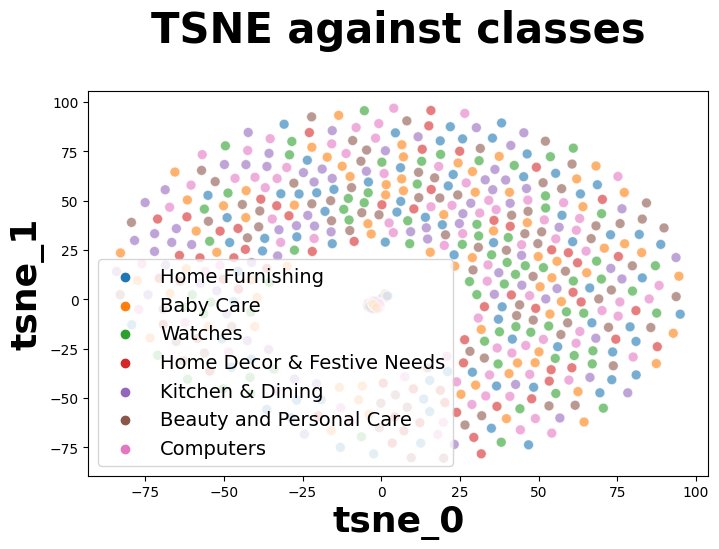

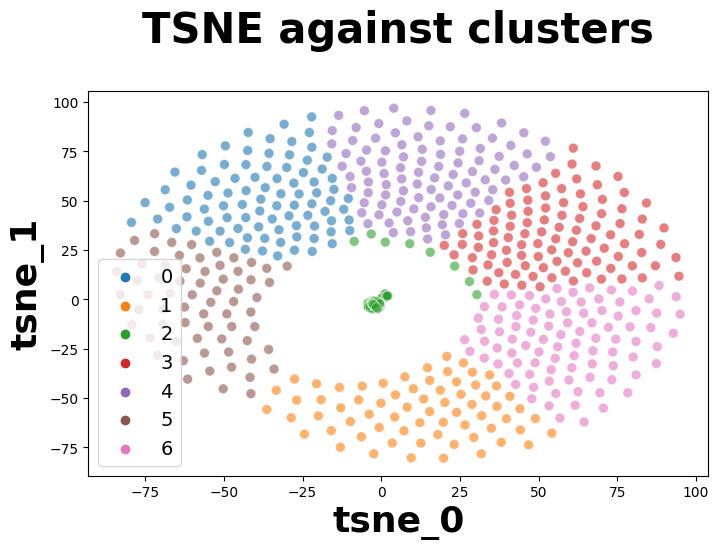

In [8]:
from flipkart_utils import get_class_labels, get_class_names
from im_ml import tsne_reduction, get_tsne_km_clusters, show_tsne
cla_labels = get_class_labels()
cla_names = get_class_names()
tsne_pca_feats = tsne_reduction(pca_feats)
pca_clu_labels = get_tsne_km_clusters(tsne_pca_feats)
show_tsne(tsne_pca_feats, cla_names, "classes")
show_tsne(tsne_pca_feats, pca_clu_labels, "clusters")

### kPCA

In [9]:
from sklearn import decomposition
n_components = None   # keep all non null
svd_solver = 'linear'   # {default: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’}

print("Dimensions before kPCA:", feats.shape)
kpca = decomposition.KernelPCA(
    n_components=n_components,
    random_state=42
)
kpca_feats = kpca.fit_transform(feats)
print("Dimensions after kPCA:", kpca_feats.shape)

Dimensions before kPCA: (1050, 716)
Dimensions after kPCA: (1050, 715)


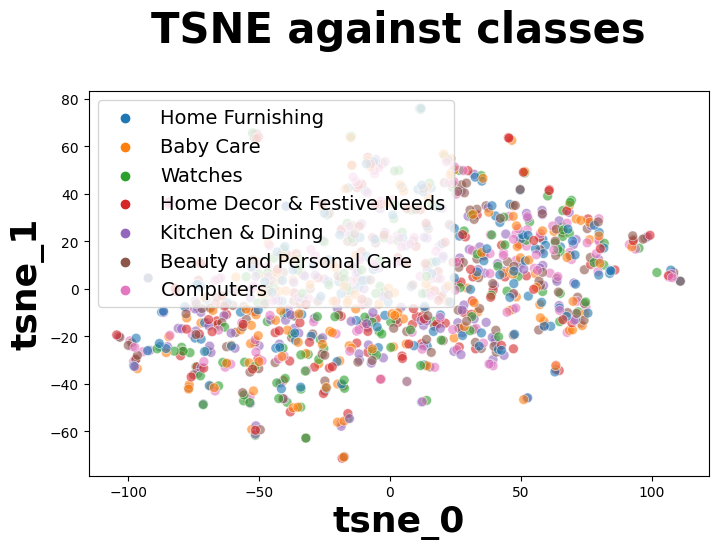

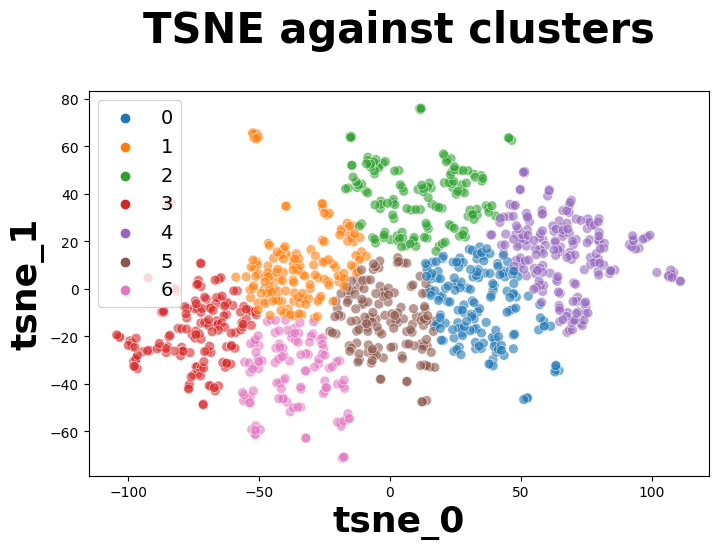

In [10]:
from flipkart_utils import get_class_labels, get_class_names
from im_ml import tsne_reduction, get_tsne_km_clusters, show_tsne
cla_labels = get_class_labels()
cla_names = get_class_names()
tsne_kpca_feats = tsne_reduction(kpca_feats)
kpca_clu_labels = get_tsne_km_clusters(tsne_kpca_feats)
show_tsne(tsne_kpca_feats, cla_names, "classes")
show_tsne(tsne_kpca_feats, kpca_clu_labels, "clusters")

# Algorithme de Hungarian

Objectif : aligner les indices de clusters d'une exécution à la suivante, y compris avec quelques données supplémentaires.

La fonction `scipy.optimize.linear_sum_assignment` est utilisée pour résoudre des problèmes d'affectation de type "minimum de somme linéaire", où l'on a une matrice de coûts et où l'objectif est d'affecter des lignes à des colonnes de manière à minimiser la somme des coûts associés. Pour utiliser cette fonction pour aligner les numéros de clusters d'un k-means entre deux exécutions, vous devriez utiliser une matrice de coûts qui reflète la similitude entre les clusters d'une exécution et les clusters de l'autre exécution.

Pour mettre en oeuvre cette fonction, voici les étapes à suivre :

* Créez une matrice de coûts C de taille (n_clusters1, n_clusters2), où n_clusters1 est le nombre de clusters dans la première exécution et n_clusters2 est le nombre de clusters dans la deuxième exécution. Cette matrice de coûts peut être remplie avec des valeurs de similitude entre les clusters, comme la distance euclidienne entre les centroïdes des clusters.

* Appliquez la fonction scipy.optimize.linear_sum_assignment en lui passant la matrice de coûts C en entrée. Cela renvoie un tuple (row_ind, col_ind) où row_ind et col_ind sont des tableaux d'indices correspondant aux lignes et colonnes de la matrice de coûts qui sont affectées pour minimiser la somme des coûts.

* Utilisez les tableaux row_ind et col_ind pour créer un mapping entre les clusters de la première exécution et les clusters de la deuxième exécution. Pour cela, on peut utiliser la fonction zip pour créer un dictionnaire qui relie les indices des clusters de la première exécution aux indices des clusters de la deuxième exécution.

* Utilisez ce dictionnaire pour aligner les numéros de clusters entre les deux exécutions en remplaçant les numéros de clusters de la première exécution par les numéros de clusters de la deuxième exécution correspondants.

In [3]:
# la fonction est dans text_example.py :
# TODO : commencer à transférer le code dans ma partie principale

import numpy as np
from scipy.optimize import linear_sum_assignment

def match_class(clu_labels, cla_labels):
    """
    Find the best matching between true and predicted classes based on
    the size of the intersection between the indices of 
    y_clu and y_cla.

    Args:
    - clu_labels (np.ndarray): predicted classes
    - cla_labels (np.ndarray): true classes

    Returns:
    - class_mapping (np.ndarray): best match between the predicted
    and true classes based on the size of the intersection 
    between the indices of clu_labels and cla_labels.

    See:
    https://en.wikipedia.org/wiki/Assignment_problem
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
    """
    if isinstance(clu_labels, list):
        clu_labels = np.array(clu_labels)
    if isinstance(cla_labels, list):
        cla_labels = np.array(cla_labels)

    n_clusters = np.unique(clu_labels).shape[0]
    n_classes = np.unique(cla_labels).shape[0]
    match_matrix = np.zeros((n_clusters, n_classes))

    # print(match_matrix)
    for clu in range(n_clusters):
        for cla in range(n_classes):
            intersection = np.intersect1d(
                np.where(clu_labels == clu),
                np.where(cla_labels == cla)
            )
            match_matrix[clu, cla] = intersection.shape[0]

    # display(match_matrix)
    return linear_sum_assignment(-match_matrix)[1]

In [11]:
clu_cla_map = match_class(kpca_clu_labels, cla_labels)
display(clu_cla_map)

array([5, 0, 4, 1, 2, 3, 6], dtype=int64)

In [ ]:
# Find the best matching between true and predicted classes
mapping = match_class(kpca_clu_labels, cat_codes)
_clu_labels = np.array([mapping[clu] for clu in clu_labels])